<a href="https://colab.research.google.com/github/uol-mediaprocessing/group-projects-coloring-book/blob/master/main_coloring_book_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Interactiv Coloring Book**


![alt text](https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-coloring-book/master/images/coloring_book_picture.png)

**Group Members**
* Johannes Scheibe
* Thilo von Glan 
* Jill Baumann

## **Project Planning**
"Create a coloring template out of a photo"

**Scenarios**
* colorbookly pictures
* blurred images
* high detailled images
* existing images from coloring books
* faces

**Steps**

0.   Accusation of Pictures 

*   We have now made some "easy to colorbook" pictures ourselves, still more could be made and "embarrassingly colorbookly" pictures from the internet may be acquired if need be.

1.   Preprocessing of picture

*   We have already tried out differnt methods and decided for these:
  * Loading of images
  * Gaussian Blur
  * Grayscale
  * Colorset
*   We have rewriten them to enable one to call these methods like functions so one is able to use differnt filters in quick succesion. We still haven't made a final decision on which filters we want to use and when.


2.   Image Segmantation

*   We have succesfully implemented our own form of the SLIC algorithim and also a well working color quantization and color replacing to segment pictures. For this form of SLIC we have written an addition, which outlines the pixels and removes all color from them except one pixel in the middle showing the mean color of each Superpixel. We have also found good parameters for Slic

*  Then we have also implemented a well functioning Face Recognition using landmarks.

*  Only thing remaining would be to combine both methods in one

3.   Postprocessing

*   After some tests we have decided that three functions could be interesting to us in the postprocessing of pictures:
  * Edge Detection
  * Canny
  * Adaptive Thresholding
  Just as with the preprocessing a final decision on what methods to use hasn't been made.

4.   Extracting Colors and assigning correct numbers to fields

*   We have implemted a version for Slic where colors are defined by one pixel in the middel for rhe larger superpixels. We will probably stick with this and not try to implement numbers yet



# **Project**

## **Requierd imports**

In [1]:
# Getting of Landmarks, only has to run once
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bunzip2 "shape_predictor_68_face_landmarks.dat.bz2"

--2020-01-21 09:18:02--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  21.8MB/s    in 2.8s    

2020-01-21 09:18:10 (21.8 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [0]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import math
import dlib
from PIL import Image, ImageDraw, ImageOps
from skimage.transform import resize
from skimage import io, color


In [0]:
# Define the plot size
fig_size = [22,15]
plt.rcParams["figure.figsize"] = fig_size

## **Usefull functions**

We implemented the following functions to make our code clearer

In [0]:
# A single Image is loaded into colab and returned (name)
def load_image(name):
  link = "https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-coloring-book/master/images/" + name
  ! wget $link  
  img = cv2.imread(name)
  rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return rgb

# show an array of images 
def show(images, titles = [], y = 2):
  x = int(len(images)/2) + len(images)%2
  for i in range(len(images)):
    plt.subplot(x,y,i+1),plt.imshow(images[i], cmap='gray')
    if len(titles)!=0:
      title = titles[i%len(titles)] + " " + str(int(i/len(titles)+1))
      plt.title(title)
    plt.xticks([]),plt.yticks([])

# Apply a threshold
def adaptive_threshold(img):
  blur = gaussian_blur(img)
  adaptive = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 201, 8)
  inverted = cv2.bitwise_not(adaptive)
  return inverted

# Resize the Image to a given size  
def resize_image(img, skimage = True):
    h = img.shape[0]
    w = img.shape[1]
    diff = abs(int((h - w)/2))
    if h < w:
      new_w = diff + h
      img = img[0:h, diff:new_w]
    elif h > w:
      new_h = diff + w
      img = img[diff:new_h, 0:w]
    if skimage:
      img = resize(img, (500,500),anti_aliasing=True)
    else:
      img = cv2.resize(img, (500,500))
    return img

## **Color set**

We decided to define a fixed color set, which should be used to colorize the final output. 

The set inculdes the following colors:

*   Red: RGB: 255,0,0 
*   Yellow: RGB: 236,226,40 
*   Green: RGB: 0,255,0 
*   Blue: RGB: 0,0,255
*   Pink: RGB: 255,0,255
*   Purple: RGB: 200,0,255
*   Light blue: RGB: 191,239,255 
*   Dark blue RGB: 25,25,112 
*   Dark Green: RGB: 0,99,0 
*   Skin: RGB: 255,229,196 
*   Brown: RGB: 140,92,43 
*   Light brown: RGB: 222,184,135 
*   Dark red: RGB: 140,0,0 
*   Gray: RGB: 204,204,204 
*   White: RGB: 255,255,255 
*   Black: RGB: 0,0,0 


We implemented the color set as an array and converted it to an image. This gives us the opportunity to convert the color set into another color space with the help of cv2.cvtColor()

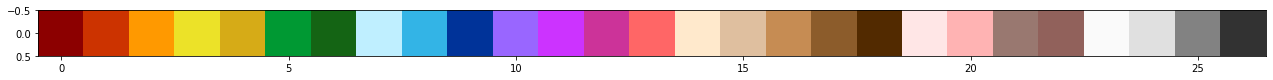

In [5]:
color_set_rgb = [[140,0,0],
                 [204,51,0],
                 [255,153,0],
                 [236,226,40],
                 [214,171,23],
                 [0,153,51],
                 [20,100,20],
                 [191,239,255],
                 [51,180,230],
                 [0,51,153],
                 [153,102,255],
                 [204,51,255],
                 [204,51,153],
                 [255,102,102],
                 [255,233,204],
                 [223,191,159],
                 [198,140,83],
                 [140,92,43],
                 [82,42,0],
                 [255,230,230],
                 [255,179,179],
                 [153,120,112],
                 [145,97, 91],
                 [250,250,250],
                 [224,224,224],
                 [130,130,130],
                 [50,50,50]]     

            
color_set = np.zeros([1,len(color_set_rgb), 3], dtype=np.uint8)
for i in range(0,len(color_set_rgb)):
  color_set[0][i] = color_set_rgb[i]

plt.imshow(color_set)

## **Input**

--2020-01-21 09:18:32--  https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-coloring-book/master/images/face1.JPG
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6521344 (6.2M) [application/octet-stream]
Saving to: ‘face1.JPG’

face1.JPG           100%[===================>]   6.22M  --.-KB/s    in 0.09s   

2020-01-21 09:18:32 (66.4 MB/s) - ‘face1.JPG’ saved [6521344/6521344]

--2020-01-21 09:18:35--  https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-coloring-book/master/images/car.JPG
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiti

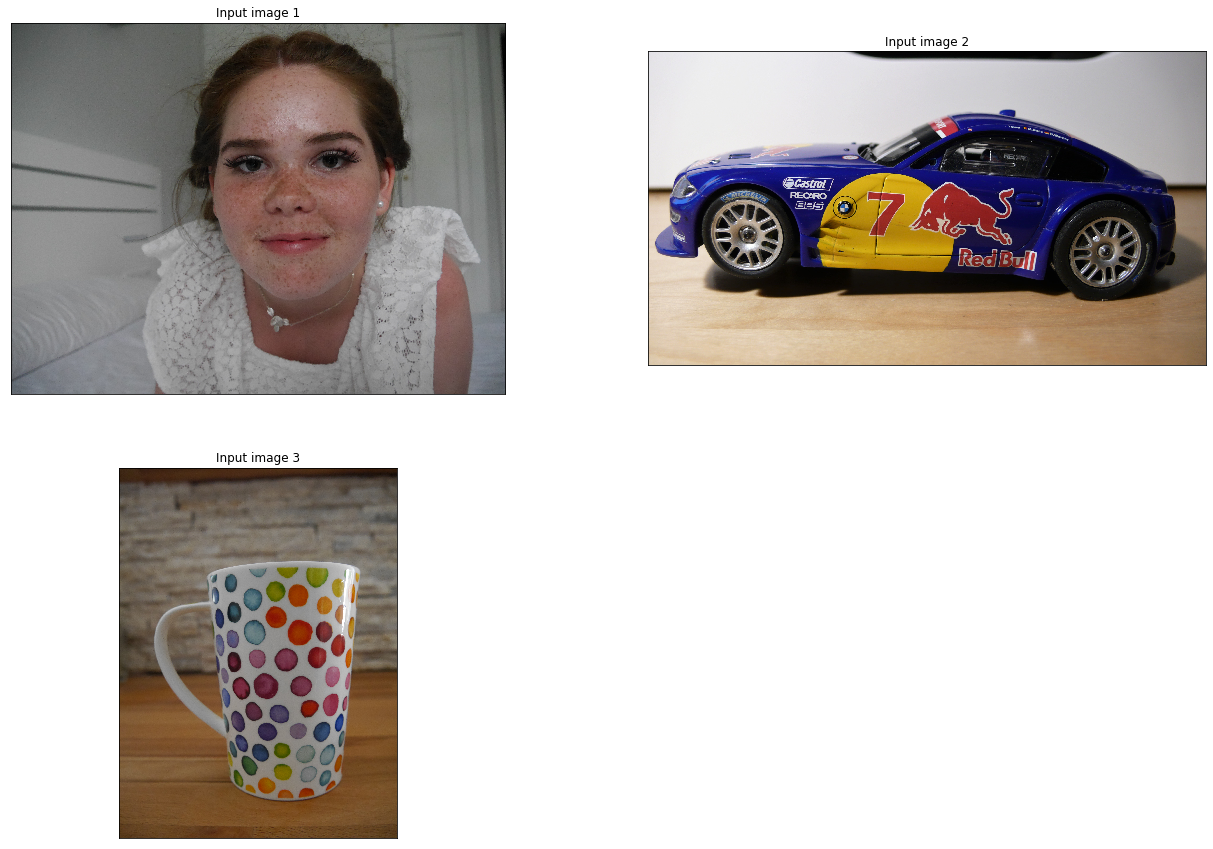

In [6]:
orginal = []
input = []

img1 = load_image("face1.JPG")
orginal.append(img1)

img2 = load_image("car.JPG")
orginal.append(img2)

img3 = load_image("cup.JPG")
orginal.append(img3)

for image in orginal:
  image = resize_image(image, skimage = False)
  input.append(image)

titles = ["Input image"]
show(orginal, titles=titles)

## **Face detection**

One defined Scenario are faces, which we need to handle separately.

So our first step is to detect this faces using landmark detection. The code is based on Andrew Jones implemantation and has a few adjustments.

Source: https://www.analytics-link.com/single-post/2019/07/17/Mapping-Facial-Landmarks-in-Python-using-OpenCV

In [0]:
# set up the 68 point facial landmark detector
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

outlines = []
parts = []
colors = []
# Loop throw the input images
for image in input:
    
  # convert to grayscale
  img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

  # detect faces in the image
  faces_in_image = detector(img_gray, 0)
  faces = []
  facial_parts = []
  mouth_color = []
  # loop through each face in image
  for f in faces_in_image:
    
    face = []
    eye_1 = []
    eye_2 = []
    mouth = []
    nose = []
    # assign the facial landmarks
    landmarks = predictor(img_gray, f)

    # unpack the needed landmark coordinates for the face regions from the dlib object into a list 
    
    # outline landmarks
    for i in range(0, 16):
      face.append((landmarks.part(i).x, landmarks.part(i).y))
    for i in range(26, 16, -1):
      face.append((landmarks.part(i).x, landmarks.part(i).y))
    faces.append(face)

    # eye landmarks
    for i in range(36, 42):
      eye_1.append((landmarks.part(i).x, landmarks.part(i).y))
    facial_parts.append(eye_1)
    for i in range(42, 48):
      eye_2.append((landmarks.part(i).x, landmarks.part(i).y))
    facial_parts.append(eye_2)

    #nose landmarks
    for i in range(31, 36):
      nose.append((landmarks.part(i).x, landmarks.part(i).y))
    nose.append((landmarks.part(27).x, landmarks.part(27).y))
    #facial_parts.append(nose)

    #mouth landmarks
    for i in range(48, 60):
      mouth.append((landmarks.part(i).x, landmarks.part(i).y))
    facial_parts.append(mouth)
      
    # avg color of the mouth
    r = 500
    g = 0
    b = 0
    for i in range(49,54):
      x = landmarks.part(i).x + int((landmarks.part(i).x - landmarks.part(i+11).x)/2)
      y = landmarks.part(i).y + int((landmarks.part(i).y - landmarks.part(i+11).y)/2)
      r+= image[x][y][0]
      g+= image[x][y][1]
      b+= image[x][y][2]
    for i in range(65,68):
      x = landmarks.part(i).x + int((landmarks.part(i).x - landmarks.part(i-9).x)/2)
      y = landmarks.part(i).y + int((landmarks.part(i).y - landmarks.part(i-9).y)/2)
      r+= image[x][y][0]
      g+= image[x][y][1]
      b+= image[x][y][2]
    r/= 12
    g/= 12
    b/= 12
    mouth_color.append((r,g,b))

  outlines.append(faces)
  parts.append(facial_parts)
  colors.append(mouth_color)

In the next step we create a mask for the face regions:

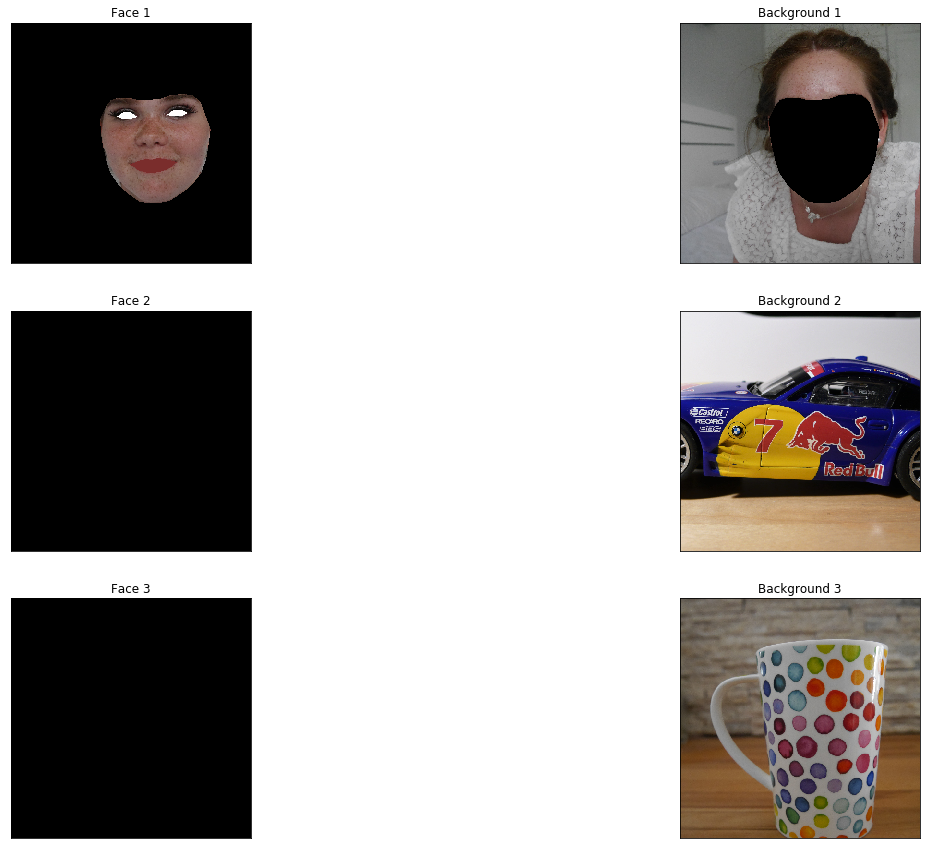

In [71]:
output_landmarks = []
masks = [] 

for i in range(0,len(outlines)):
  outline = outlines[i]
  part = parts[i]
  image = input[i] 
  color_mouth = colors[i] 

  height = image.shape[0]
  width = image.shape[1]

  # Mask the face outline
  mask_1 = Image.new('L', (width, height), 0)
  for o in outline:
    ImageDraw.Draw(mask_1).polygon(o, outline=1, fill=1)
  mask_1 = np.array(mask_1)
  face_mask_1 = np.stack((mask_1,)*3, axis=-1)

  # Mask the facial parts (eyes, mouth)
  mask_2 = Image.new('L', (width, height), 0)
  for p in part:
    ImageDraw.Draw(mask_2).polygon(p, outline=1, fill=1)
  mask = np.array(mask_2)
  face_mask_2 = np.stack((mask_2,)*3, axis=-1)
  face_mask_2 = 1 - face_mask_2
  face_mask = face_mask_1 * face_mask_2
  masks.append(face_mask_1)


  color_mask = Image.new('RGB', (width, height), 0)
  for i in range(0, len(part)):
    p = part[i]
    if (i+1)%3 == 0:
      c = color_mouth[int(i/3)]
      r = int(c[0])
      g = int(c[1])
      b = int(c[2])
      ImageDraw.Draw(color_mask).polygon(p, outline=(r,g,b), fill=(r,g,b))
    else:
      ImageDraw.Draw(color_mask).polygon(p, outline=(255,255,255), fill=(255,255,255))
  color_mask = np.array(color_mask)
  

  output_face = image * face_mask + color_mask
  output_landmarks.append(output_face)

  # Mask the background
  back_mask = (1-face_mask_1)
  masks.append(back_mask)

  output_back = (image * back_mask)
  output_landmarks.append(output_back)


  titles = ['Face','Background']
  show(output_landmarks, titles=titles)

## **SLIC**

SLIC is a clustering algorithm that segments an image based on the color similarities of the pixels.
The code is a combination of the implementation from Darshita Jain, Aleena Watson and own additions.

Sources: 
https://github.com/darshitajain/SLIC 
https://github.com/aleenawatson/SLIC_superpixels/blob/master/slic.py

In our project SLIC is used for the background and images without faces.

**Functions:**

In [0]:
# function which returns an object of class SuperPixel(height, weidth, l, a, b). Superpixels have a center(h,w) and a color(lab)
def make_superPixel(h, w,img):
    return SuperPixels(h, w,img[h,w][0],img[h,w][1],img[h,w][2])

In [0]:
# To define the initial cluster centers distanced at S
def initial_cluster_center(S,img,img_h,img_w,clusters):
    h = S // 2
    w = S // 2
    while h < img_h:
        while w < img_w:
            clusters.append(make_superPixel(h, w,img))
            w += S
        w = S // 2
        h += S
    return clusters

In [0]:
# function to calculate gradient at each pixel.
def calc_gradient(h, w,img,img_w,img_h):
    if w + 1 >= img_w:
        w = img_w - 2
    if h + 1 >= img_h:
        h = img_h - 2
    grad = img[w + 1, h + 1][0] - img[w, h][0] + img[w + 1, h + 1][1] - img[w, h][1] + img[w + 1, h + 1][2] - img[w, h][2]
    return grad

In [0]:
# function which reassign for each cluster the cluster center to the pixel having the lowest gradient
def reassign_cluster_center_acc_to_grad(clusters,img):
    for c in clusters:
        cluster_gradient = calc_gradient(c.h, c.w,img,img_w,img_h)
        for dh in range(-1, 2):
            for dw in range(-1, 2):
                H = c.h + dh
                W = c.w + dw
                new_gradient = calc_gradient(H,W, img,img_w,img_h)
                if new_gradient < cluster_gradient:
                    c.update(H, W,img[H,W][0], img[H,W][1],img[H,W][2])
                    c_gradient = new_gradient


In [0]:
#function to assign pixels to the nearest cluster using the Euclidean distance involving both color and spatial proximity.
def assign_pixels_to_cluster(clusters,S,img,img_h,img_w,tag,dis):
    for c in clusters:
        for h in range(c.h - 2 * S, c.h + 2 * S):
            if h < 0 or h >= img_h: continue
            for w in range(c.w - 2 * S, c.w + 2 * S):
                if w < 0 or w >= img_w: continue
                l, a, b = img[h,w]
                Dc = math.sqrt(math.pow(l - c.l, 2) + math.pow(a - c.a, 2) + math.pow(b - c.b, 2))
                Ds = math.sqrt(math.pow(h - c.h, 2) + math.pow(w - c.w, 2))
                D = math.sqrt(math.pow(Dc / m, 2) + math.pow(Ds /S, 2))
                if D < dis[h,w]:
                    if (h, w) not in tag:
                        tag[(h, w)] = c
                        c.pixels.append((h, w))
                    else:
                        tag[(h, w)].pixels.remove((h, w))
                        tag[(h, w)] = c
                        c.pixels.append((h, w))
                    dis[h, w] = D

In [0]:
#function to assign pixels to the nearest cluster using the Euclidean distance involving both color and spatial proximity.
def assign_pixels_to_cluster(clusters,S,img,img_h,img_w,tag,dis):
    for c in clusters:
        for h in range(c.h - 2 * S, c.h + 2 * S):
            if h < 0 or h >= img_h: continue
            for w in range(c.w - 2 * S, c.w + 2 * S):
                if w < 0 or w >= img_w: continue
                l, a, b = img[h,w]
                Dc = math.sqrt(math.pow(l - c.l, 2) + math.pow(a - c.a, 2) + math.pow(b - c.b, 2))
                Ds = math.sqrt(math.pow(h - c.h, 2) + math.pow(w - c.w, 2))
                D = math.sqrt(math.pow(Dc / m, 2) + math.pow(Ds /S, 2))
                if D < dis[h,w]:
                    if (h, w) not in tag:
                        tag[(h, w)] = c
                        c.pixels.append((h, w))
                    else:
                        tag[(h, w)].pixels.remove((h, w))
                        tag[(h, w)] = c
                        c.pixels.append((h, w))
                    dis[h, w] = D

In [0]:
# function to replace the cluster center with the mean of the pixels contained in the cluster
def update_cluster_mean(clusters):
    for c in clusters:
        sum_h = sum_w = number = 0
        for p in c.pixels:
            sum_h += p[0]
            sum_w += p[1]
            number += 1
            H = sum_h // number
            W = sum_w // number
            c.update(H, W,img[H, W][0], img[H, W][1], img[H, W][2])

In [0]:
# function to replace the cluster center with the mean of the pixels contained in the cluster
def update_cluster_mean(clusters):
    for c in clusters:
        sum_h = sum_w = number = 0
        for p in c.pixels:
            sum_h += p[0]
            sum_w += p[1]
            number += 1
            H = sum_h // number
            W = sum_w // number
            c.update(H, W,img[H, W][0], img[H, W][1], img[H, W][2])

In [0]:
# To change the color of cluster to the matching color from the color set 
def avg_color_cluster(img, clusters):
  image = np.copy(img)
  color_set_lab = color.rgb2lab(color_set)
  for c in clusters:
      for p in c.pixels:
          image[p[0],p[1]][0] = c.l
          image[p[0],p[1]][1] = c.a
          image[p[0],p[1]][2] = c.b
      # To change the color of cluster center to the matching color from the color set  
      for j in range(0,len(color_set[0])):
          a = color_set_lab[0][j]
          b = [c.l,c.a,c.b]
          value = math.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2 + (a[2] - b[2])**2)
          if(j==0):
              best_value = value
              image[c.h, c.w][0] = a[0]
              image[c.h, c.w][1] = a[1]
              image[c.h, c.w][2] = a[2]
          elif(value<best_value):
              image[c.h, c.w][0] = a[0]
              image[c.h, c.w][1] = a[1]
              image[c.h, c.w][2] = a[2]
              best_value = value 
  return color.lab2rgb(image)

In [0]:
# To change the color of cluster to the matching color from the color set 
def matched_color_cluster(img, clusters):
  image = np.copy(img)
  for c in clusters:
    b = [c.l,c.a,c.b]
    for j in range(0,len(color_set[0])):
      color_set_lab = color.rgb2lab(color_set)
      a = color_set_lab[0][j]
      value = math.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2 + (a[2] - b[2])**2)
      if(j==0):
          best_value = value
          c.l = a[0]
          c.a = a[1]
          c.b = a[2]
      elif(value<best_value):
          best_value = value 
          c.l = a[0]
          c.a = a[1]
          c.b = a[2]
  for c in clusters:
      for p in c.pixels:
          image[p[0],p[1]][0] = c.l
          image[p[0],p[1]][1] = c.a
          image[p[0],p[1]][2] = c.b
  return color.lab2rgb(image)

In [0]:
# outline the boarder of each cluster
def display_contours(img, clusters):
    image = np.zeros([img_h,img_w, 3], dtype=np.uint8)
    image.fill(255)
    image = color.rgb2lab(image)
    
    cluster_map = -1 * np.ones(img.shape[:2])
    for i in range(0,len(clusters)):
        c = clusters[i]
        for p in c.pixels: 
            cluster_map[p[0],p[1]] = i

    is_taken = np.zeros(image.shape[:2], np.bool)
    contours = []

    for i in range(img_w):
        for j in range(img_h):
            nr_p = 0
            for dx, dy in [(-1,0), (-1,-1), (0,-1), (1,-1), (1,0), (1,1), (0,1), (-1,1)]:
                x = i + dx
                y = j + dy
                if x>=0 and x < img_w and y>=0 and y < img_h:
                    if is_taken[y, x] == False and cluster_map[j, i] != cluster_map[y, x]:
                        nr_p += 1
            if nr_p >= 2:
                is_taken[j, i] = True
                contours.append([j, i])
    for i in range(len(contours)):
        image[contours[i][0], contours[i][1]] = [0.0, 0.0, 0.0]
    kernel = np.ones((2,2),np.uint8)
    image = cv2.erode(image,kernel,iterations = 1)

    # To change the color of cluster center to the matching color from the color set  
    color_set_lab = color.rgb2lab(color_set)
    for c in clusters:
        for j in range(0,len(color_set[0])):
            a = color_set_lab[0][j]
            b = [c.l,c.a,c.b]
            value = math.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2 + (a[2] - b[2])**2)
            if(j==0):
                best_value = value
                for dx, dy in [(-1,0), (-1,-1), (0,-1), (1,-1), (1,0), (1,1), (0,1), (-1,1), (0,0)]:
                  h = c.h + dx
                  w = c.w + dy
                  image[h, w][0] = a[0]
                  image[h, w][1] = a[1]
                  image[h, w][2] = a[2]
            elif(value<best_value):
                best_value = value 
                for dx, dy in [(-1,0), (-1,-1), (0,-1), (1,-1), (1,0), (1,1), (0,1), (-1,1), (0,0)]:
                  h = c.h + dx
                  w = c.w + dy
                  image[h, w][0] = a[0]
                  image[h, w][1] = a[1]
                  image[h, w][2] = a[2]
    return color.lab2rgb(image)

In [0]:
# A class to initialize the super pixels, of the form - [h,y,l,a,b].
class SuperPixels(object):

    def __init__(self, h, w, l=0, a=0, b=0):
        self.update(h, w, l, a, b)
        self.pixels = []

    def update(self, h, w, l, a, b):
        self.h = h
        self.w = w
        self.l = l
        self.a = a
        self.b = b

In [0]:
def slic(S,img,img_h,img_w,clusters,tag,dis,iter):
    clusters = initial_cluster_center(S,img,img_h,img_w,clusters)
    reassign_cluster_center_acc_to_grad(clusters,img)
    for i in range(iter): # usually the algortihm converges within 10 iterations
        assign_pixels_to_cluster(clusters,S,img,img_h,img_w,tag,dis)
        update_cluster_mean(clusters)
        if i == (iter - 1) : # to print the output after 10 iterations
            avg_color = avg_color_cluster(img, clusters)
            matched_color = matched_color_cluster(img, clusters)
            outline = display_contours(img, clusters)
    return outline, avg_color, matched_color

**Execution**

We decided to use a total of 400 Superpixel.

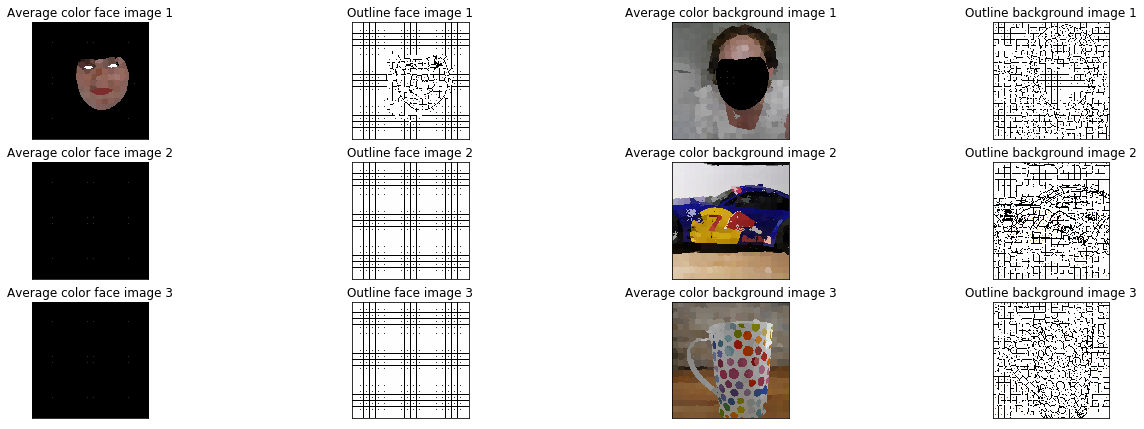

In [72]:
output_slic = []
extended_output = []
output_matched = []

for image in output_landmarks:
    
  # input images are resized to (400 x 400) for processing
  img = resize_image(image)

  # convert RGB to LAB
  img = color.rgb2lab(img)

  k = 400   # Number of Super pixels
  m = 21    # Constant for normalizing the color proximity, range of m = [1,40]

  img_h = img.shape[0] # Image Height
  img_w = img.shape[1] # Image Width

  N = img_h * img_w  # Total number of pixels in the image
  S = int(math.sqrt(N /k)) # average size of each superpixel

  clusters = []
  tag = {}
  # initialize the distance between pixels and cluster center as infinity
  dis = np.full((img_h, img_w), np.inf)

  outline,avg_color, matched_color = slic(S,img,img_h,img_w,clusters,tag,dis,7)

  extended_output.append(avg_color)
  output_matched.append(matched_color)
  extended_output.append(outline)

  output_slic.append(outline)

titles = ["Average color face image", "Outline face image", "Average color background image", "Outline background image"]
show(extended_output, titles=titles,y = 4)

## **Combine Background and Face**

SLIC produces two images: one segmentation of the background, one segmentation of the face.

In this step we need to combine both.

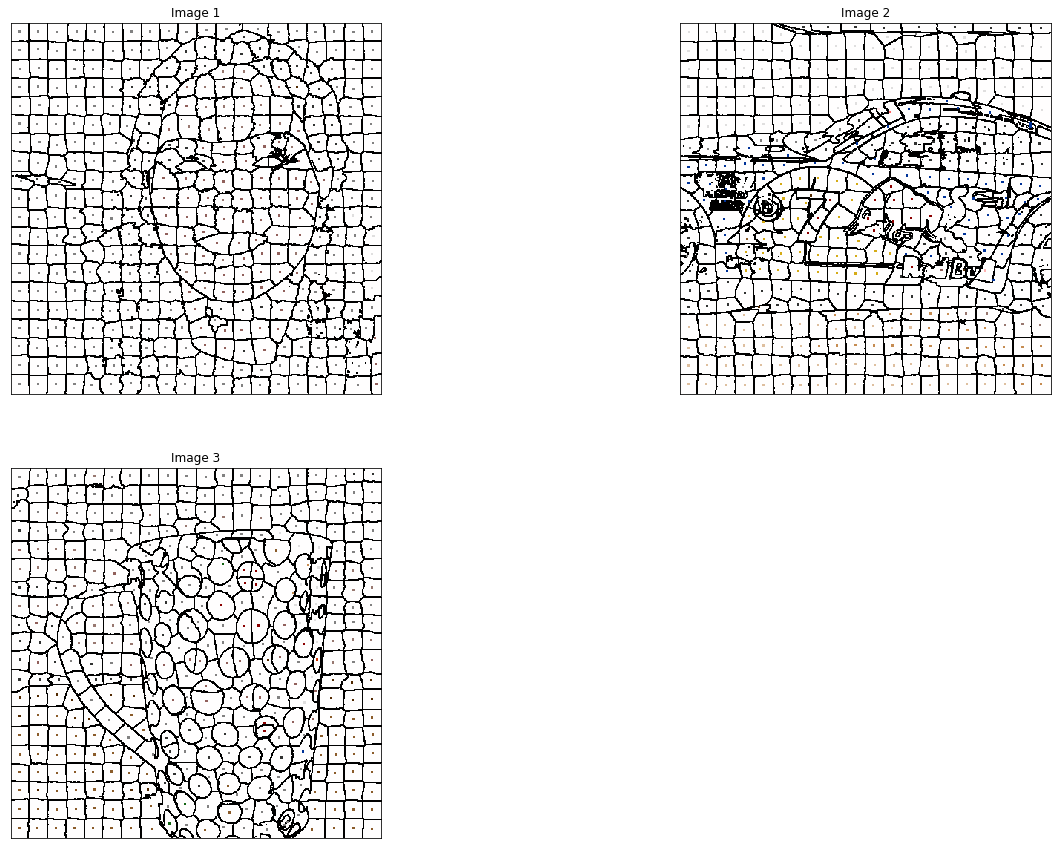

In [73]:
output_combined = []
for i in range(0, len(output_slic),2):

  face = output_slic[i] * masks[i]
  background = output_slic[i+1] * masks[i+1]
  result =  face + background
  output_combined.append(result)

titles = ["Image"]
show(output_combined, titles=titles)


## **Threshold**

To keep the significant contours we use a threshold, which will be added to the Slic output in the next step.

In addition to thiswe use Mop

Threshold: https://docs.opencv.org/master/d7/d4d/tutorial_py_thresholding.html

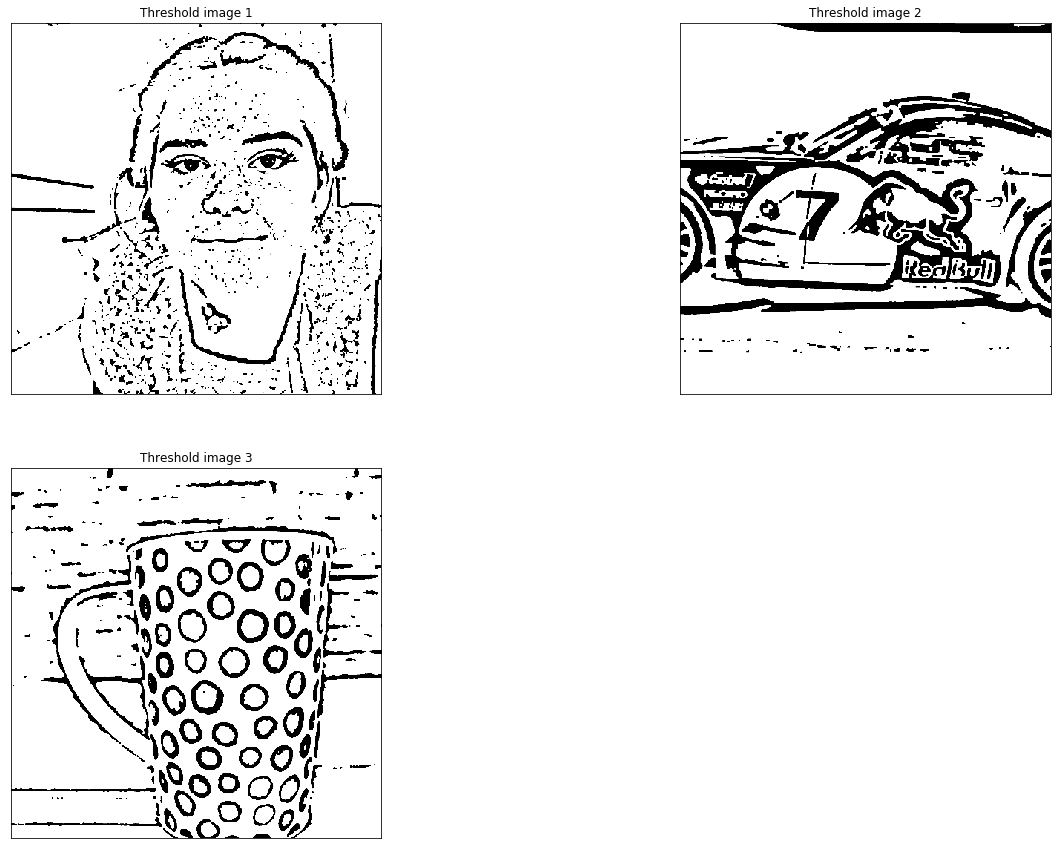

In [74]:
output_threshold = []
for image in orginal:

  # Prepocessing
  blur = cv2.GaussianBlur(image, (9, 9), 0)
  gray_image = cv2.cvtColor(blur, cv2.COLOR_RGB2GRAY)

  # Threshold
  threshold = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 201, 8)
  inverted = cv2.bitwise_not(threshold)

  # Opening,Closing
  kernel = np.ones((9,9),np.uint8)
  opening = cv2.morphologyEx(inverted, cv2.MORPH_OPEN, kernel)
  kernel = np.ones((9,9),np.uint8)
  closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

  outline = np.stack((closing,)*3, axis=-1)
  outline = resize_image(outline, skimage=False)
  outline = outline/255

  output_threshold.append(outline)

titles = ['Threshold image']
show(output_threshold, titles=titles)

## **Final output**

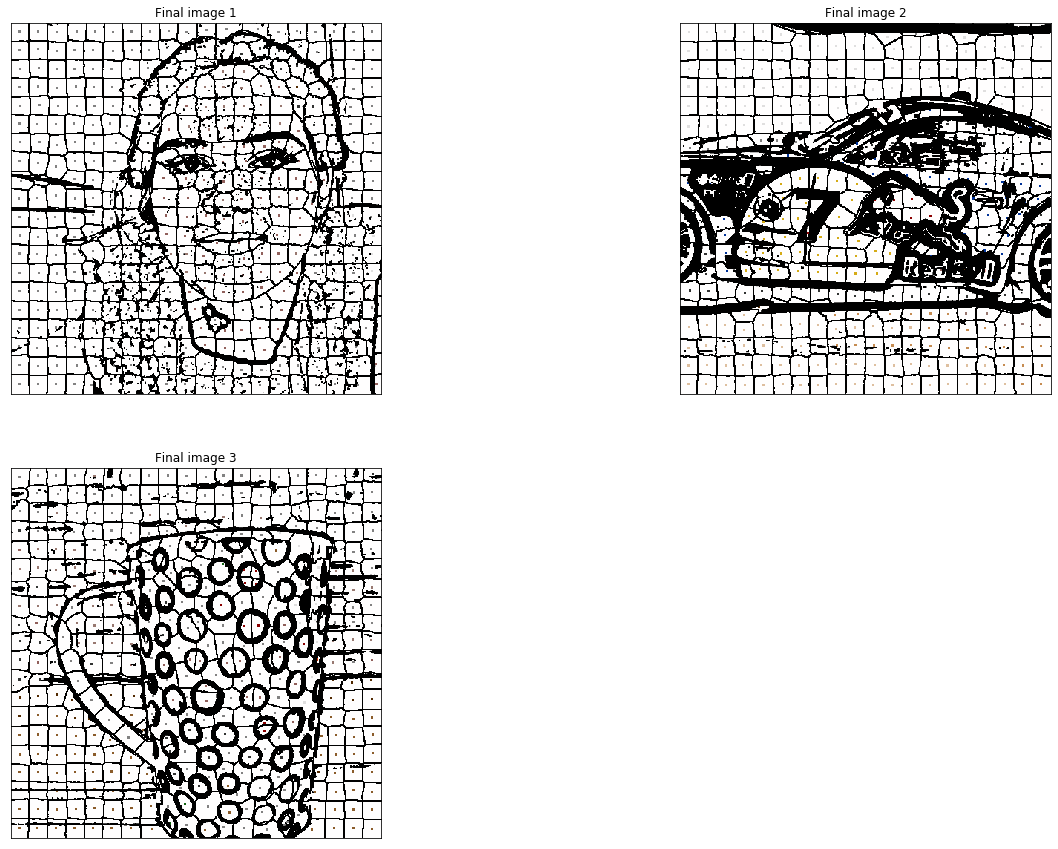

In [75]:
final = []
for i in range(0,len(output_combined)):
  final.append(output_combined[i] * output_threshold[i])

titles = ['Final image']
show(final,titles)


Show how the picture would looked colorized with the given color set

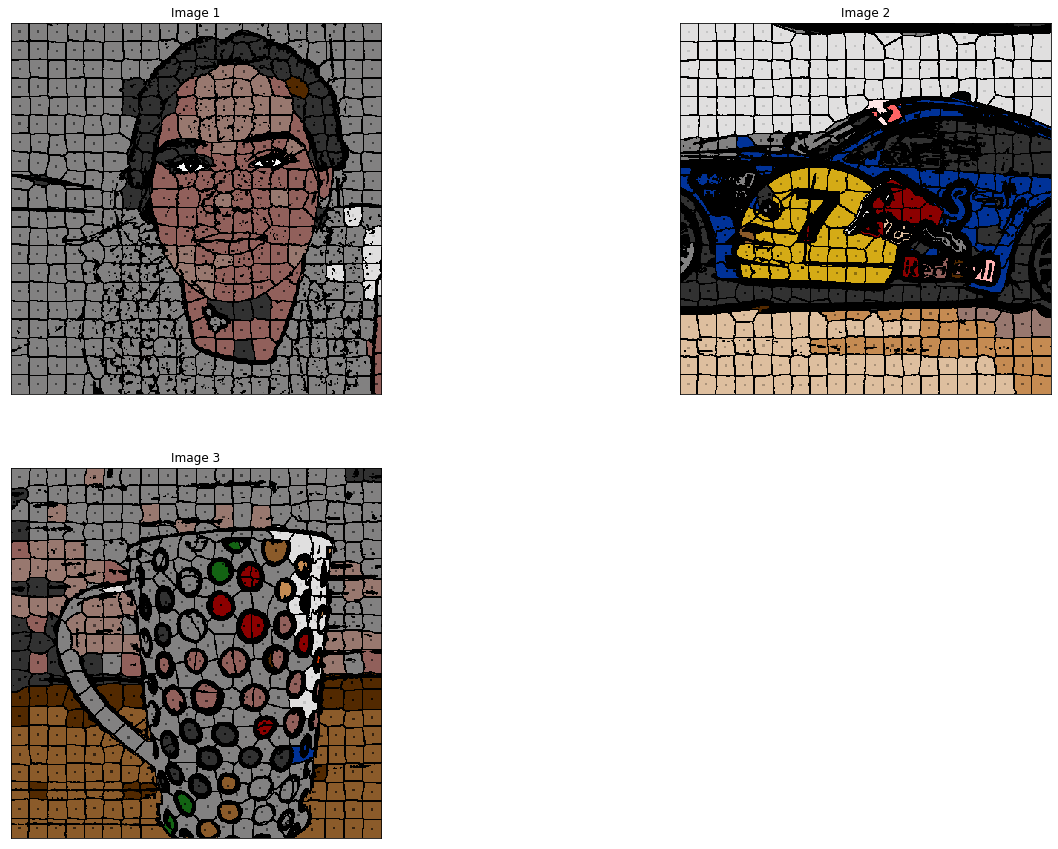

In [76]:
colorized = []
for i in range(0, len(final)):
  face = output_matched[i*2] * masks[i*2]
  background = output_matched[i*2+1] * masks[i*2+1]
  result =  face + background

  outline = final[i]
  bw_img = color.rgb2gray(outline)
  bw_img = np.stack((bw_img,)*3, axis=-1)
  colorized.append(result * bw_img)

titles = ["Image"]
show(colorized, titles=titles)

## **Deep Learning**

**Color quantization**

In [0]:
# Color quantization using k-means Clustering
# kmeans(samples, nclusters, criteria, attemps, flags)
# samples Z: Input of np.float32 data type
# nclusters K: number of clusters/ colors
# criteria: iteration termination criteria
#   (termination criteria, max_iter, epsilon)
# attemps: number of iterations - returns best result from the diffrent iterations
# flag: specifies how initial centers are choosen
# Code source: https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_ml/py_kmeans/py_kmeans_opencv/py_kmeans_opencv.html
def color_quantization(img):
  Z = img.reshape((-1,3))

  # convert to np.float32
  Z = np.float32(Z)

  # define criteria, number of clusters(K) and apply kmeans()
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  K = 8
  ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

  # Now convert back into uint8, and make original image
  center = np.uint8(center)
  res = center[label.flatten()]
  result = res.reshape((img.shape))
  return result

**Color replacing**

In [0]:
# Function, which checks if an array already contains a color
def contains_color(list1, list2):
  for e in list1:
    if e[0] == list2[0] and e[1] == list2[1] and e[2] == list2[2]:
      return True
  return False

# Get the colors which are left after quantization
def get_colors(img):
  h = img.shape[0]
  w = img.shape[1]
  colors = []
  for y in range(0, h):
    for x in range(0, w):
      if not contains_color(colors, img[y,x]):
        colors.append(img[y,x])
  return colors

# Match the colors from the color set to the colors in the picture
def match_colors(colors):
  color_set_lab = cv2.cvtColor(color_set, cv2.COLOR_RGB2LAB)
  for i in range(len(colors)):
    colors[i] = np.append(colors[i],[0,10000])
    e = colors[i]
    for j in range(0,len(color_set[0])):   
      color = color_set_lab[0][j]
      a = [color[0]/255*100,color[1]-128,color[2]-128]
      b = [e[0]/255*100,e[1]-128,e[2]-128]
      value = math.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2 + (a[2] - b[2])**2)
      if(value<e[4]):
        e[3] = j
        e[4] = value



# Replace with matched colors
def replace_colors(img, colors):
  color_set_lab = cv2.cvtColor(color_set, cv2.COLOR_RGB2Lab)
  final = img.copy()
  for e in colors:  
    mask = cv2.inRange(img, e[0:3], e[0:3])
    final[mask > 0] = color_set_lab[0][e[3]]
  final = cv2.cvtColor(final, cv2.COLOR_Lab2RGB)
  return final

# Combine all functions
def color_replacing(img):
  lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)

  picture_colors = get_colors(lab)
  match_colors(picture_colors)
  result = replace_colors(lab, picture_colors)
  return result

To optimize edge detection we used deep learning.

Holistically-Nested Edge Detection is using a caffemodel, which is a pretrained model using deep learning. 

Source: https://github.com/ashukid/hed-edge-detector and own adjustment

Before we can start, we have to load the caffemodel and the prototxt file, which shows the infrastractur.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


We copy the prototxt file and the caffemodel file from google drive.

In [0]:
!cp "./drive/My Drive/deploy.prototxt" "deploy.prototxt"

In [0]:
!cp "./drive/My Drive/hed_pretrained_bsds.caffemodel" "hed_pretrained_bsds.caffemodel"

Now we can use these two files for the foloowing code.

--2020-01-20 19:01:43--  https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-coloring-book/master/images/face1.JPG
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6521344 (6.2M) [application/octet-stream]
Saving to: ‘face1.JPG.1’

face1.JPG.1         100%[===================>]   6.22M  --.-KB/s    in 0.05s   

2020-01-20 19:01:43 (127 MB/s) - ‘face1.JPG.1’ saved [6521344/6521344]

(691, 921)
<class 'numpy.ndarray'>
238
0
(691, 921, 3)
(691, 921, 3)


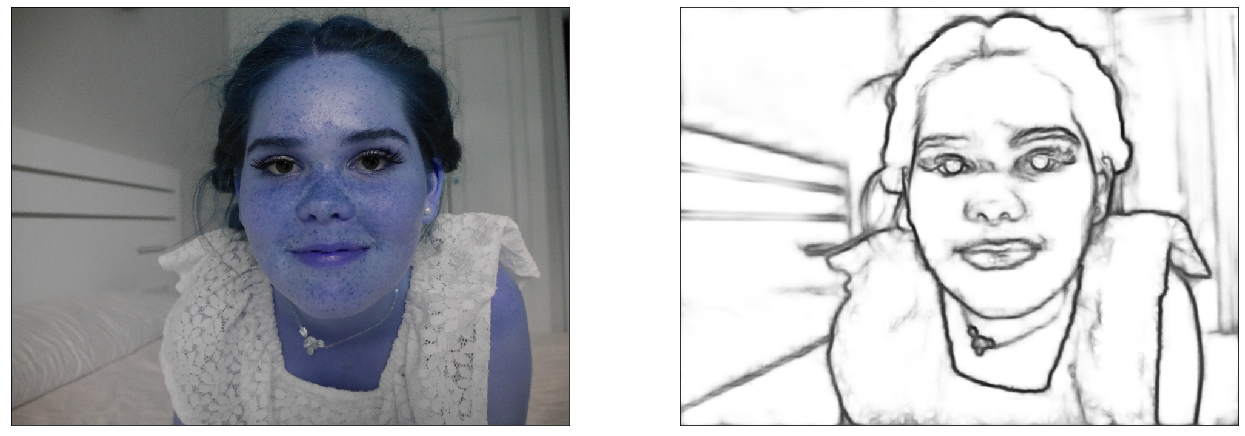

In [0]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

class CropLayer(object):
    def __init__(self, params, blobs):
        self.xstart = 0
        self.xend = 0
        self.ystart = 0
        self.yend = 0

    # Our layer receives two inputs. We need to crop the first input blob
    # to match a shape of the second one (keeping batch size and number of channels)
    def getMemoryShapes(self, inputs):
        inputShape, targetShape = inputs[0], inputs[1]
        batchSize, numChannels = inputShape[0], inputShape[1]
        height, width = targetShape[2], targetShape[3]

        self.ystart = int((inputShape[2] - targetShape[2]) / 2)
        self.xstart = int((inputShape[3] - targetShape[3]) / 2)
        self.yend = self.ystart + height
        self.xend = self.xstart + width

        return [[batchSize, numChannels, height, width]]

    def forward(self, inputs):
        return [inputs[0][:,:,self.ystart:self.yend,self.xstart:self.xend]]

# Load the model.
proto = "deploy.prototxt"
caffe = "hed_pretrained_bsds.caffemodel"
net = cv.dnn.readNetFromCaffe(proto, caffe)
cv.dnn_registerLayer('Crop', CropLayer)

!wget https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-coloring-book/master/images/face1.JPG
image=cv.imread("face1.JPG")

width = int(image.shape[1] / 100  * 20)
height = int(image.shape[0] / 100 * 20 )
dim = (width, height) 
image=cv.resize(image,(dim))

inp = cv.dnn.blobFromImage(image, scalefactor=1.0, size=dim,
                           mean=(104.00698793, 116.66876762, 122.67891434),
                           swapRB=False, crop=False)
net.setInput(inp)
out = net.forward()

out = out[0, 0]
out = cv.resize(out, (image.shape[1], image.shape[0]))

print(out.shape)
out=cv.cvtColor(out,cv.COLOR_GRAY2BGR)
out = 255 * out
out = out.astype(np.uint8)

print(type(out))
print(np.max(out))
print(np.min(out))
print(out.shape)
print(image.shape)
con=np.concatenate((image,out),axis=1)
cv.imwrite('out.jpg',con)

out = cv.bitwise_not(out)

images = [image,out]
show(images)

To reduce the colors and replace the colors by our own colors given in the color set we are using color quantization and replacing.

--2020-01-20 19:37:47--  https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-coloring-book/master/images/face1.JPG
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6521344 (6.2M) [application/octet-stream]
Saving to: ‘face1.JPG.6’

face1.JPG.6         100%[===================>]   6.22M  40.2MB/s    in 0.2s    

2020-01-20 19:37:47 (40.2 MB/s) - ‘face1.JPG.6’ saved [6521344/6521344]



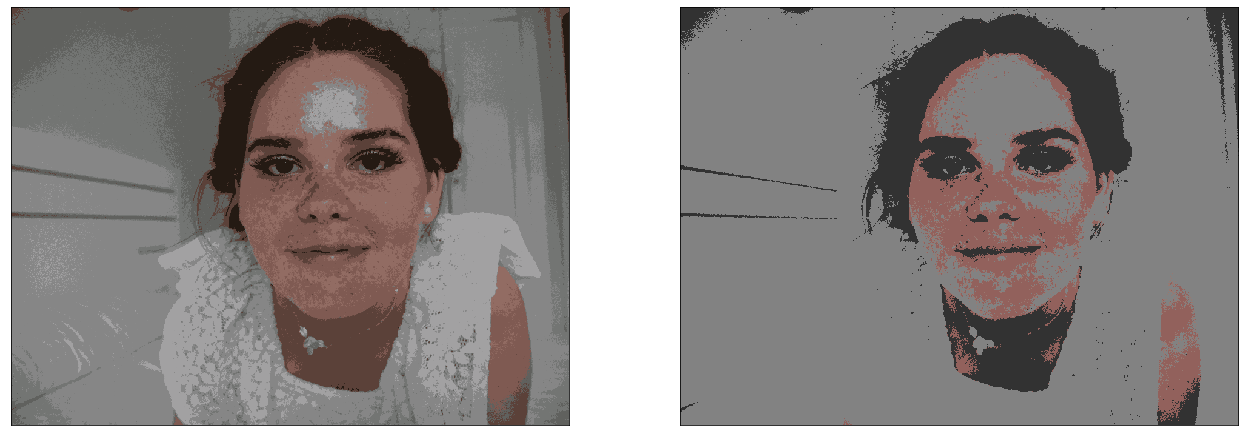

In [0]:
img = load_image("face1.JPG")

reduced = color_quantization(img)
replaced = color_replacing(replaced)

width = int(img.shape[1] / 100  * 20)
height = int(img.shape[0] / 100 * 20 )
dim = (width, height) 
replaced=cv2.resize(replaced,(dim))
reduced=cv2.resize(reduced,(dim))
image=cv2.resize(img,(dim))

images = [reduced,replaced]
show(images)

Next step is to match the lines and colors.

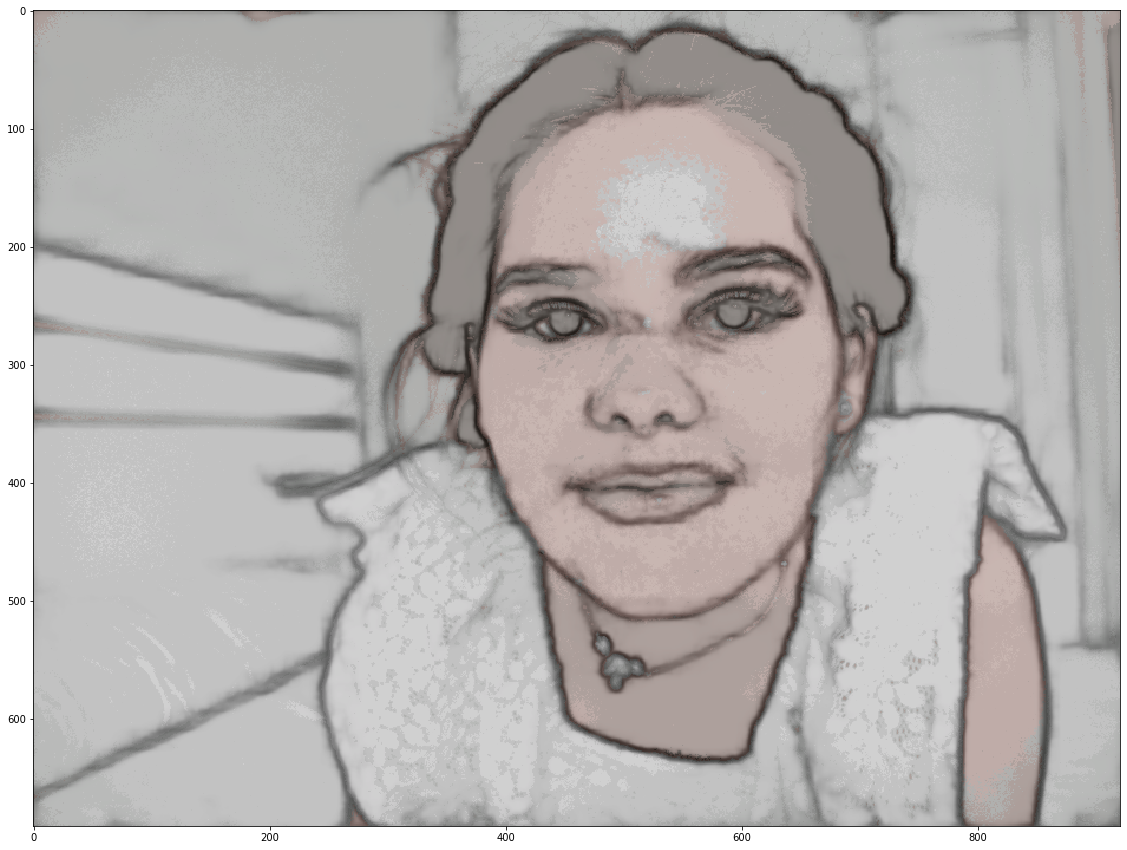

In [0]:
alpha = 0.5
beta = (1.0 - alpha)
dst = cv2.addWeighted(out, alpha, reduced, beta, 0.0)
plt.imshow(dst)